### Setup
---
<br>
<br>
<br>
<br>
<br>


## Imports

In [55]:
def setup(basedir=None):
    if basedir == None:
#         basedir: str = "D:\Datasets\KITTI_cvlibs"
        basedir: str = "/media/kats/DocumentData/Data/KITTI_cvlibs"

    #             basedir = "/media/michaelkatsoulis/Data raw/Datasets/KITTI_cvlibs/"
    date = "2011_09_26"
    #     drive = "0001"
    drive = "0113"
    return pykitti.raw(basedir, date, drive)

In [56]:
import cv2
import pykitti
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import time
from scipy.spatial import Delaunay
import scipy.spatial.distance as ssd
from pathlib import Path
from os.path import isfile

import pickle

# from jupyterthemes import jtplot
# jtplot.style()

# Need to declare notebook first so that code can switch between inline and notebook
%matplotlib notebook

%matplotlib inline

In [57]:
im_fig_size = np.array([15, 5])
data = setup()
frame_num = 0
#     print(data.calib)
cam2_image, cam3_image = data.get_rgb(frame_num)
# imgL = cv2.imread(np.array(cam2_image), cv2.COLOR_RGB2BGR)
# imgR = cv2.cvtColor(np.array(cam3_image), cv2.COLOR_RGB2BGR)

imgL = np.array(cam2_image)
imgR = np.array(cam3_image)

lidar_data = data.get_velo(frame_num)

np.set_printoptions(precision=4, suppress=True)

## Utility Functions:
---
<br>
<br>
<br>


In [58]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


def render_points(points, img_shape=[375, 1242], normalise=False, dilation_size=1, colour_map=-1):
    valid = np.where(
        (points[:, 0] >= 0) & (points[:, 1] >= 0) & (points[:, 0] < img_shape[1]) & (points[:, 1] < img_shape[0])
    )
    points = points[valid].round().astype(int)
    img_shape = np.array(img_shape).reshape((-1))
    #     img_shape[:2] += 1

    if colour_map != -1:
        #         print("Using cmap")
        if len(img_shape) < 3:
            img_shape = np.hstack((img_shape, 3))
        rendered = np.zeros(img_shape, dtype=np.uint8)

        minima = min(points[:, 2])
        maxima = max(points[:, 2])

        norm = colors.Normalize(vmin=minima, vmax=maxima, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=colour_map)
        cs = mapper.to_rgba(points[:, 2])[:, :3] * 255

        rendered[points[:, 1], points[:, 0]] = cs
        rendered = cv2.dilate(rendered, np.ones((dilation_size, dilation_size)))
        return rendered

    else:
        if len(img_shape) > 2:
            img_shape = img_shape[:2]

        rendered = np.zeros(np.array(img_shape) + 1)
        rendered[points[:, 1], points[:, 0]] = points[:, 2]
        if dilation_size > 1:
            rendered = cv2.dilate(rendered, np.ones((dilation_size, dilation_size)))
        return rendered


def pointcloud_to_img_frame(pointcloud, img_height, img_width, Tr, P, rtrn_reflectance=True, rtrn_depth=False):
    #     Trimming pointcloud for speedup
    pointcloud = pointcloud[pointcloud[:, 0] > 0].copy()  # Everything in front of camera

    xyz = pointcloud[:, :3]
    reflectance = pointcloud[:, 3]

    #     making the pointcloud homogenous
    xyz = np.hstack((xyz, np.ones((xyz.shape[0], 1))))
    #     xyz now [ X, Y, Z, 1]

    #     transforming lidar into camera frame
    cam_xyz = Tr.dot(xyz.T).T
    #     lidar_depth = cam_xyz[:, 2].copy()  #Everything in front of camera
    cam_xyz = cam_xyz / cam_xyz[:, 2].reshape((-1, 1))

    img_xyz = P.dot(cam_xyz.T).T  # image frame
    pixel_coords = img_xyz.round(0).astype(int)
    indicies = np.where(
        (pixel_coords[:, 0] >= 0)
        & (pixel_coords[:, 1] >= 0)
        & (pixel_coords[:, 0] < imgL.shape[1])
        & (pixel_coords[:, 1] < imgL.shape[0])
    )

    if rtrn_reflectance:
        rtrn = np.hstack((xyz[indicies, :-1].reshape((-1, xyz.shape[-1] - 1)), reflectance[indicies].reshape((-1, 1))))
    elif rtrn_depth:
        # pythag to get distance of ray to point.
        d = np.sqrt(np.sum(xyz[indicies][:, :2] ** 2, axis=1))
        rtrn = np.hstack((xyz[indicies, :-1].reshape((-1, xyz.shape[-1] - 1)), d.reshape((-1, 1))))
    else:
        rtrn = xyz[indicies]
    return rtrn


def pointcloud_to_image(pointcloud, img_height, img_width, Tr, P, useDepth=True):
    #     Trimming pointcloud for speedup
    xyzc = pointcloud_to_img_frame(
        pointcloud, img_height, img_width, Tr, P, rtrn_reflectance=(not useDepth), rtrn_depth=useDepth
    )
    xyz = xyzc[:, :-1]
    c = xyzc[:, -1]

    #     making the pointcloud homogenous
    xyz = np.hstack((xyz, np.ones((xyz.shape[0], 1))))
    #     xyz now [ X, Y, Z, 1]

    #     transforming lidar into camera frame
    cam_xyz = Tr.dot(xyz.T).T
    lidar_depth = cam_xyz[:, 2].copy()  # Everything in front of camera
    cam_xyz = cam_xyz / cam_xyz[:, 2].reshape((-1, 1))

    img_xyz = P.dot(cam_xyz.T).T

    pixel_coords = img_xyz.round(0).astype(int)
    indicies = np.where(
        (pixel_coords[:, 0] >= 0)
        & (pixel_coords[:, 1] >= 0)
        & (pixel_coords[:, 0] < imgL.shape[1])
        & (pixel_coords[:, 1] < imgL.shape[0])
    )

    pixel_coords = pixel_coords[indicies]
    pixel_coords.max(axis=0)
    render = np.zeros((img_height, img_width))

    for j, (u, v) in enumerate(pixel_coords[:, :2]):
        #         if useDepth: render[v, u] = lidar_depth[j]
        #         else:
        #             render[v, u] = (reflectance[j] * 255).astype(int)
        render[v, u] = c[j]

    return render


def plot_pointcloud_on_image(
    im, render, rtrn_img=False, dilate_kernel_size=2, grayscale=False, colormap=cv2.COLORMAP_HSV
):
    im = np.array(im).copy()
    fig_l, ax_l = plt.subplots(1, 1, figsize=im_fig_size)
    kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    dst = (255 * (render.copy()) / render.max()).astype(np.uint8)
    dst = cv2.dilate(dst, kernel, iterations=1)
    inds = np.where(dst > 0)
    dst = cv2.applyColorMap(dst, colormap)

    if grayscale:
        if len(im.shape) == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    else:
        # ensure three image channels if there is not three.
        if len(im.shape) != 3:
            print("Converting to 3 channel image")
            im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

    img_dist = im.copy()
    img_dist[inds] = dst[inds]
    if rtrn_img:
        return img_dist
    # ax_l[1].imshow(cv2.dilate(render_reflectance.copy(), kernel, iterations=1))
    # ax_l[1].imshow(img_ref)
    ax_l.imshow(img_dist)
    ax_l.axis("off")
    ax_l.set_title("Lidar plot coloured by depth", fontsize=im_fig_size[0])


%matplotlib inline
# render_lidar = pointcloud_to_image(
#     lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20
# )
# plot_pointcloud_on_image(imgL, render_lidar, dilate_kernel_size=3, grayscale=False, colormap=cv2.COLORMAP_HSV)
# plot_pointcloud_on_image(np.zeros(imgL.shape), render_lidar, dilate_kernel_size=3,grayscale=False, colormap=cv2.COLORMAP_HSV)

Visualising features:


In [59]:
def visualise_keypoints(
    img, keyPoints, title=None, show=False, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
):
    img_kp = cv2.drawKeypoints(img, keyPoints, None, color, flags)

    if show:
        plt.imshow(img_kp)
        if title != None:
            plt.title(title)

    return img_kp

Triangle Functions and Manipulation


In [60]:
def get_closest_triangles(samples, tri_obj, verticies=False, return_bcs=True, fix_tris=True, precision=7, debug=False):

    # find the simplicies for all contained points.
    tris = tri_obj.find_simplex(samples[:, :2])

    centroids = tri_obj.points[tri_obj.simplices].sum(axis=1) / 3

    inds = np.array(np.where(tris < 0)[0])

    if return_bcs:
        bcs = -99 * np.ones((samples.shape[0], 3))
        for i, t in enumerate(tris):
            pt = samples[i, :2]
            b = tri_obj.transform[t, :2].dot(np.transpose(pt.reshape((1, -1)) - tri_obj.transform[t, 2]))
            bcs[i] = np.c_[np.transpose(b), 1 - b.sum(axis=0)].round(precision)

        inds = np.array(np.where((bcs.round(precision).min(axis=1) < 0) + (bcs.max(axis=1).round(precision) > 1))[0])

        if debug:
            print("Number of initial wrong points:", inds.shape, np.sum(tris < 0))

    for i, pt in enumerate(samples[inds][:, :2]):
        dist = np.sum((centroids - pt) ** 2, axis=1)
        tris[inds[i]] = dist.argmin()  # closest simplice

        if return_bcs:

            if not fix_tris:
                bcs[inds[i]] = -np.ones((1, 3))
            else:
                verts = tri_obj.points[tri_obj.simplices[tris[inds[i]]]]
                d = np.sum((verts - pt) ** 2, axis=1)
                v_arg = d.argsort()
                #             get lines for all edges
                #             Get line from pt to centroid
                #             check where intersect is between verticies
                #             pt of intersect is closest.

                #             r = p2-p
                #             s = q2-q
                #             t and u are parameters
                #             line1 = p + t*r
                #             line2 = q + u*s
                #             Want: p + t*r = q + u*s
                #             t = (q − p) × s / (r × s)
                #             u = (q − p) × r / (r × s)
                #             if r × s ≠ 0 and 0 ≤ t ≤ 1 and 0 ≤ u ≤ 1
                #                 Then intersection between points
                p = pt
                r = centroids[tris[inds[i]]] - pt
                q = verts[v_arg[0]]  # Closest point

                edge_pt = q.copy()
                for v in verts[v_arg[1:]]:
                    s = v - q
                    c = np.cross(r, s)
                    if c == 0:
                        if debug:
                            print("Divide by 0 in get_closest_triangles")
                        continue
                    t = np.cross((q - p), s) / c
                    u = np.cross((q - p), r) / c

                    if (0 <= t <= 1) and (0 <= u <= 1):
                        edge_pt = p + t * r
                        break
                b = tri_obj.transform[tris[inds[i]], :2].dot(
                    np.transpose(edge_pt.reshape((1, -1)) - tri_obj.transform[tris[inds[i]], 2])
                )
                bcs[inds[i]] = np.c_[np.transpose(b), 1 - b.sum(axis=0)]

    if verticies:
        cont_tri_vert = samples[tri_obj.simplices[tris]]
        return cont_tri_vert

    if return_bcs:
        bcs = bcs.round(precision)
        #         if debug:print("Other BCs:")
        if debug:
            print(
                "Number of wrong fixed points:",
                np.sum((bcs[inds].round(precision).min(axis=1) < 0) + (bcs[inds].max(axis=1).round(5) > 1)),
            )
        if debug:
            print("Number of wrong points:", np.sum(bcs.min(axis=1) < 0 + (bcs.max(axis=1).round(precision) > 1)))
        return tris, bcs

    return tris


def get_general_barycentric(tri, pts):
    bcs = np.zeros((pts.shape[0], 3))
    for i in range(pts.shape[0]):
        pt = pts[i, :2]
        t = tri.find_simplex(pt)
        b = tri.transform[t, :2].dot(np.transpose(pt.reshape((1, -1)) - tri.transform[t, 2]))
        bcs[i] = np.c_[np.transpose(b), 1 - b.sum(axis=0)]
    return bcs


def get_mesh_error(
    mesh_obj, samples, mesh_points, error_ord=2, precision=5, bounding_shape=[], Fix_mesh=True, debug=True
):
    r"""
    Returns error from point to barycentric projection of point in triangle.
    If point not in any triangle, use barycentric defined point on closest edge of closest triangle
    
    Params:
        error_ord: ord for np.linalg.norm
            mean squared error if error_ord = 2
    
    
    Returns:
        ndarray (n, 3)
            - n points, Error in X, Y and Z
            Should be no X & Y error if in a triangle.
    """
    proj_samples = interpolate_mesh_pts(mesh_obj, samples, mesh_points, Fix_pts_outside=Fix_mesh)

    dist = samples - proj_samples

    if np.shape(bounding_shape)[0] > 0:
        valid = np.where(
            (proj_samples[:, 0] >= 0)
            & (proj_samples[:, 1] >= 0)
            & (proj_samples[:, 0] < bounding_shape[1])
            & (proj_samples[:, 1] < bounding_shape[0])
        )
        if debug:
            if dist.shape[0] - np.shape(valid)[-1]:
                print(f"{dist.shape[0]-np.shape(valid)[-1]} points found outside mesh")
                print(".... Disgarding pts outside")

        dist = dist[valid]

    if error_ord > 2:
        error = np.linalg.norm(dist, ord=error_ord) / dist.shape[0]
    else:
        error = (dist ** 2).sum() / dist.shape[0]

    #     Return Error.
    return error


def interpolate_mesh_pts(mesh_obj, samples, mesh_points, precision=6, Fix_pts_outside=True):
    r"""
    Assumes mesh is in xy plane

    Returns 3D interpolated points (or points on closest triangle edge if outside of mesh.)
    """
    #     Get closest triangles
    tris, bcs = get_closest_triangles(samples, mesh_obj, return_bcs=True, fix_tris=Fix_pts_outside)
    bcs = bcs.round(precision)
    #         Redundancy check to make sure points are on triangle edge for those outside mesh_obj

    #     Calculate Euclidean error in X, Y and Z
    pts = mesh_points[mesh_obj.simplices[tris]]
    return (bcs.reshape(-1, 3, 1) * pts).sum(axis=1)


def get_mesh_interpolated_error(
    mesh_obj_1,
    mesh_points_1,
    mesh_obj_2,
    mesh_points_2,
    image_shape,
    interpolate_step_size=5,
    error_ord=2,
    precision=5,
    bounding_shape=[],
    Fix_mesh=True,
    return_vector=False,
    debug=False,
):
    def make_grid():
        xs = np.arange(0, image_shape[1] - 1, interpolate_step_size)
        ys = np.arange(0, image_shape[0] - 1, interpolate_step_size)
        global m_grid
        m_grid = np.meshgrid(xs, ys)

    if "m_grid" in globals():
        if debug:
            print("Sampling grid made already")
            print(
                "Size match = ",
                (np.all(np.equal(np.array(image_shape) // interpolate_step_size, np.array(np.shape(m_grid)[1:])))),
            )
        if ((m_grid[0][0, 1] - m_grid[0][0, 0]) != interpolate_step_size) or not (
            np.all(np.equal(np.array(image_shape[:2]) // interpolate_step_size, np.array(np.shape(m_grid)[1:])))
        ):
            if debug:
                print(".... Made at wrong interpolate_step_size. \n.... Remaking")
            make_grid()
    else:
        make_grid()

    if debug:
        print("Mesh sampling:")
    sample_points = np.stack((m_grid[0].ravel(), m_grid[1].ravel())).T
    s = time.time()
    grid_mesh_1 = interpolate_mesh_pts(mesh_obj_1, sample_points, mesh_points_1, precision, Fix_mesh)
    grid_mesh_2 = interpolate_mesh_pts(mesh_obj_2, sample_points, mesh_points_2, precision, Fix_mesh)

    if debug:
        print(".... Time taken: ", np.round((time.time() - s), 4), "s")
    if debug:
        print(".... Done")

    if grid_mesh_1.shape != grid_mesh_2.shape:
        if debug:
            print("Grids not equal")

    if return_vector:
        if error_ord > 2:
            e = [np.linalg.norm(grid_mesh_1 - grid_mesh_2, ord=error_ord, axis=1), sample_points]
        else:
            e = np.sum(((grid_mesh_1 - grid_mesh_2) ** 2) ** (1 / 2), axis=1)

        return e, sample_points
    else:
        if error_ord > 2:
            e = np.linalg.norm(grid_mesh_1 - grid_mesh_2, ord=error_ord)
        else:
            e = np.sum(((grid_mesh_1 - grid_mesh_2) ** 2) ** (1 / 2))

    return e


def get_mesh_hausdorff_error(mesh_0, mesh_1):

    e1 = ssd.directed_hausdorff(mesh_0, mesh_1)
    e2 = ssd.directed_hausdorff(mesh_1, mesh_0)

    #     hausdorff_sd = cv2.createHausdorffDistanceExtractor()
    #     d1 = hausdorff_sd.computeDistance(mesh_0, mesh_1)
    #     d2 = hausdorff_sd.computeDistance(mesh_1, mesh_0)

    return [e1, e2][np.argmax((e1[0], e2[0]))]

# LiDAR to Triangular meshes
---
<br>
<br>
<br>
<br>
<br>


In [61]:
# cropped_lidar = pointcloud_to_img_frame(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)



# # %matplotlib notebook

# fig_lc= plt.figure(figsize=[20,10])
# cropped_lidar_subsampled = cropped_lidar[::10]
# ax_lc = fig_lc.add_subplot(111, projection='3d')
# ax_lc.scatter3D(cropped_lidar_subsampled[:,0], cropped_lidar_subsampled[:,1], cropped_lidar_subsampled[:,2],s=1, c=cropped_lidar_subsampled[:,3])
# ax_lc.set_xlabel("X")
# ax_lc.set_ylabel("Y")
# ax_lc.set_zlabel("Z")


# ax_lims = [cropped_lidar_subsampled.min(),cropped_lidar_subsampled.max()]
# ax_lc.set_xlim(ax_lims)
# ax_lc.set_ylim([-cropped_lidar_subsampled.max(),cropped_lidar_subsampled.max()])
# ax_lc.set_zlim([0,cropped_lidar_subsampled.max()/2])
# ax_lc.view_init(elev=15., azim=180)
# ax_lc.set_title("3D projection of lidar points", fontsize=im_fig_size[0])

# fig_lc_2d = plt.figure(figsize=im_fig_size)
# ax_lc_2d = fig_lc_2d.add_subplot(111)
# ax_lc_2d.scatter(cropped_lidar_subsampled[:,0], cropped_lidar_subsampled[:,1] ,s=4, c=cropped_lidar_subsampled[:,-1])  #cv2.applyColorMap(cropped_lidar_subsampled[:,3].astype(np.uint8), cv2.COLORMAP_SPRING))
# ax_lc_2d.set_xlabel("X")
# ax_lc_2d.set_ylabel("Y")
# ax_lc_2d.set_xlim([0, cropped_lidar_subsampled[:,0].max()])
# ax_lc_2d.set_title("2D projection of lidar points", fontsize=im_fig_size[0])


# plt.show()

# Exploring Geometric Error at points
---
<br>
<br>
<br>
<br>
<br>


## Note on error in sampling

Because lidar pointclouds are polar in nature, subsampling every nth point will lead to uneven distributions. 

- Furthest points will be sampled even less than they already are
- Closest points may be over represented. 

<br>
<br>

This could be a good thing as it provides a strong bias towards close points but the problem is that variations in the mesh at distance will count as errors as sparse sampling cannot accomidate variation in the environment. 

The plot below exemplifies this problem. 

! Note how sparse the mesh becomes at distance.

In [62]:
# sample_rate = 50
# cropped_lidar = pointcloud_to_img_frame(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)
# cropped_lidar_subsampled = cropped_lidar[::sample_rate]

# cropped_triangles = Delaunay(cropped_lidar_subsampled[:, :2])

# tri_num = cropped_triangles.simplices.max() // 2
# tmp = cropped_lidar_subsampled[cropped_triangles.simplices[tri_num]]

# %matplotlib inline

# # ---------------------------------------------------------------------
# # 3D Plots
# # ---------------------------------------------------------------------

# fig = plt.figure(figsize=[15, 15])
# fig.tight_layout(pad=2)
# ax = fig.add_subplot(121, projection='3d')
# # Plot triangles
# ax.scatter(cropped_lidar_subsampled[:, 0],
#            cropped_lidar_subsampled[:, 1],
#            cropped_lidar_subsampled[:, 2],
#            c=cropped_lidar_subsampled[:, -1],
#            s=4)
# ax_lims = [cropped_lidar_subsampled.min(), cropped_lidar_subsampled.max()]
# ax.set_xlim(ax_lims)
# ax.set_ylim([-cropped_lidar_subsampled.max(), cropped_lidar_subsampled.max()])
# ax.set_zlim([0, cropped_lidar_subsampled.max() / 2])
# ax.set_title(f"Lidar Points with sampling every {sample_rate}th point", fontsize=20)
# ax.view_init(elev=15., azim=180)



# ax = fig.add_subplot(122, projection='3d')
# # Plot triangles
# ax.plot_trisurf(cropped_lidar_subsampled[:, 0],
#                 cropped_lidar_subsampled[:, 1],
#                 cropped_lidar_subsampled[:, 2],
#                 color='none',
#                 edgecolor='blue',
#                 triangles=cropped_triangles.simplices)
# ax_lims = [cropped_lidar_subsampled.min(), cropped_lidar_subsampled.max()]
# ax.set_xlim(ax_lims)
# ax.set_ylim([-cropped_lidar_subsampled.max(), cropped_lidar_subsampled.max()])
# ax.set_zlim([0, cropped_lidar_subsampled.max() / 2])
# ax.set_title(f"Mesh after sampling every {sample_rate}th point", fontsize=20)
# ax.view_init(elev=15., azim=180)




# # ---------------------------------------------------------------------
# # 2D Plots
# # ---------------------------------------------------------------------

# fig_tri_2d = plt.figure(figsize=[im_fig_size[0], 3*im_fig_size[1]])
# fig_tri_2d.tight_layout(pad=3)
# ax_tri_2d = fig_tri_2d.add_subplot(211)

# ax_tri_2d.scatter(cropped_lidar_subsampled[:, 0],
#                   cropped_lidar_subsampled[:, 1],
#                   c=cropped_lidar_subsampled[:, -1],
#                   s=10)

# ax_tri_2d.set_xlabel("X")
# ax_tri_2d.set_ylabel("Y")
# ax_tri_2d.set_title(f"2D projection of every {sample_rate}th point",
#                     fontsize=im_fig_size[0])


# ax_tri_2d = fig_tri_2d.add_subplot(212)
# ax_tri_2d.triplot(cropped_lidar_subsampled[:, 0],
#                   cropped_lidar_subsampled[:, 1],
#                   triangles=cropped_triangles.simplices)

# ax_tri_2d.set_xlabel("X")
# ax_tri_2d.set_ylabel("Y")
# ax_tri_2d.set_title(f"2D mesh after sampling every {sample_rate}th point",
#                     fontsize=im_fig_size[0])



# plt.show()
# print(
#     "Large oversampling of points that are near the lidar. \n Points further away are not represented as well."
# )

# Error Metrics
<br>
<br>
<br>


In [63]:
# pts_all = pointcloud_to_img_frame(lidar_data, imgL.shape[0], imgL.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20)[:,:3]
# pts_sampled = pts_all.copy()[::50]
# mesh = Delaunay(pts_sampled[:,:2])

### Euclidean distance to triangle plane
<br>
<br>
<br>

Finding the triangle containing the point. 

- If point in triangle:
    - Getting the Z height of the plane above the point

- if point outside all triangles:
    - get euclidean distance to nearest edge

- Get MSE for each triangle


In [64]:
# c_tris = np.zeros(pts_outside.shape[0], dtype=int)
# for i, pt in enumerate(pts_outside[:,:2]):
#     dist = np.sum((mesh.points - pt)**2, axis=1)dd
#     c = mesh.points[dist.argsort()][:10] # 10 closest points
#     c_sim = mesh.find_simplex(c) # closest triangles by simplex found from points 
#     c_centers = (mesh.points[mesh.simplices[sim]].sum(axis=1)/3) # centers
#     closest_tri = c_sim[np.sum((c_centers - pt)**2, axis=1).argmin()]
#     print(f"{i}: Pt: {pt},\t\tTri: {closest_tri}")
#     c_tris[i] = closest_tri

In [65]:
# # get containing triangles:
# cont_tri = mesh.find_simplex(pts_all[:,:2])
# # Distance to points:
# inds = np.where(cont_tri<0)
# pts_outside = pts_all[inds].copy()
# print("Num Points Outside Mesh:", pts_outside.shape[0])

# # ----------------------------------------------
# #  getting closest points to ALL outside
# closest_pts = np.ones((pts_outside.shape[0],2))
# for i, pt in enumerate(pts_outside[:,:2]):
#     closest_pts[i] = mesh.points[(np.sum((mesh.points - pt)**2, axis=1)).argmin()]
    

# # ----------------------------------------------
# # For second plot: selecting points
# pt = pts_outside[0, :2]
# dist = np.sum((mesh.points - pt)**2, axis=1)
# c = mesh.points[dist.argsort()][:10] # 10 closest points
# sim = mesh.find_simplex(c)
# t = mesh.points[mesh.simplices[sim]]

# c_cen = (mesh.points[mesh.simplices[sim]].sum(axis=1)/3) # centers
# closest_ts = sim[np.sum((c_cen - pt)**2, axis=1).argsort()]



# fig_c, ax_c = plt.subplots(1,1,figsize=im_fig_size)
# fig_c.tight_layout(pad=2)
# ax_c.scatter(pts_outside[:,0], pts_outside[:,1], label= "Points outside mesh")
# # ax_c.scatter(closest_pts[:,0], closest_pts[:,1], label="closest points in mesh")
# ax_c.scatter(closest_pts[:,0], closest_pts[:,1], label="closest points in mesh")
# ax_c.set_title("Points outside the mesh and their closest points inside the mesh")
# ax_c.legend(loc='best')
# ax_c.set_xlabel("X")
# ax_c.set_ylabel("Y")

# plt.show()


# fig_close, ax_close = plt.subplots(1,1,figsize=im_fig_size)
# fig_close.tight_layout(pad=2)

# # ax_close.scatter(pts_outside[:,0], pts_outside[:,1], label= "Points outside mesh")
# ax_close.scatter(c[:,0], c[:,1], label="closest points in mesh")
# ax_close.triplot(t[:,:,0].flatten(), t[:,:,1].flatten())

# for j, s in enumerate(t):
#     p = s.mean(axis=0)
#     ax_close.text(p[0], p[1], '#%d' %  sim[j], ha='center') # label dangles
    
    
# ax_close.text(pt[0], pt[1], "Pt outside", ha="left", fontsize=im_fig_size[0])
# ax_close.scatter(pt[0], pt[1], c="red")

# ax_close.set_title("Points outside the mesh and their closest_pt points inside the mesh")
# ax_close.legend(loc='best')
# ax_close.set_xlabel("X")
# ax_close.set_ylabel("Y")


# plt.show()

# print("Closest triangles to Pt Outside")
# print(closest_ts)

Need to ammend closest triangle list so that distances can be calculated


In [66]:
# print((c_bc.min(axis=1).round(3)<0).sum())
# pts_all[c_bc.max(axis=1)>1].shape

# # c_bc.min()


# t = mesh.find_simplex(pts_all[:, :2])  
# np.array(np.where(t < 0))[0].shape

In [67]:
# (c_bc.min(axis=1).round(3)<0).sum()

In [68]:
# print("Before:")

# if cont_tri.min() <0:
#     print(f"{np.sum(cont_tri==-1)}\t of {cont_tri.shape[0]} points found outside of mesh")
# else:
#     print("All points inside of mesh")
    
    
# print("\nAfter:")
# print(f"{np.sum(closest_tris==-1)}\t of {closest_tris.shape[0]} points found outside of mesh")
# print(f"Number of invalid BCs is: {np.sum(c_bc.round(5).max(axis=1)>1)}")

In [69]:
# print(get_mesh_error(mesh, pts_all[::50], pts_all))
# print(get_mesh_error(mesh, pts_all[::10], pts_all))
# print(get_mesh_error(mesh, pts_all[::20], pts_all))


In [70]:
# error=get_mesh_error(mesh, pts_all[::50], pts_all)

# fig_e = plt.figure(figsize=im_fig_size)
# # fig_e.tight_layout(pad=5)

# plt_error = error.sum(axis=1)
# ax_1 = fig_e.add_subplot(111)
# ax_1.hist(plt_error, bins=100)
# ax_1.set_xlabel("Sum of Error [m]")
# ax_1.set_ylabel("Occurances")
# ax_1.set_title(f"Histogram over range ({plt_error.min().round()} : {plt_error.max().round()}) with error rejection")

# plt.show()

In [71]:
# tri, bc = get_closest_triangles(pts_all, mesh, return_bcs=True)
# wrong = np.where(bc.max(axis=1)>1)
# if np.shape(wrong)[1]>0:
#     w_tris = tri[wrong]
#     w_bc = bc[wrong]
#     w_pt = pts_all[wrong]


#     fig_wrong = plt.figure(figsize=(im_fig_size[0], 3*im_fig_size[1]))
#     fig_wrong.tight_layout(pad=2.)

#     ax = fig_wrong.add_subplot(211)
#     ax.scatter(w_pt[:,0], w_pt[:,1], label="Wrong Points")

#     ax.triplot(mesh.points[:,0],mesh.points[:,1], triangles=mesh.simplices, c="skyblue", label="Right Triangles")
#     ax.triplot(mesh.points[:,0],mesh.points[:,1], triangles=mesh.simplices[w_tris], c="red", label="Wrong Triangles")


#     ax.legend(loc="best")


#     ax = fig_wrong.add_subplot(212)
#     ax.scatter(pts_outside[:,0], pts_outside[:,1],s=20, c='g', label="Outside Points")
#     ax.scatter(w_pt[:,0], w_pt[:,1],s=5, c='r',label="Wrong Points")

#     ax.legend(loc="best")
#     plt.show()

#     print(f"Num wrong points: {w_pt.shape[0]}")

## Hausdroff Error
<br>
<br>

Still to be implemented. <br>
Methods are set out in the paper:

http://www.cmap.polytechnique.fr/~peyre/cours/x2005signal/mesh_mesh.pdf
<br>
<br>


# Finding best sample points in an image
---

<br>
<br>

TODO
- Need to map lidar to image. 
- Evaluate the most trackable points
- Find error at those points
- Try find relationship between error and any other metric that can be useful in prediction.


First need to smooth the image.


## Corner Detection




In [72]:
imgL_0 = np.array(data.get_cam0(0))
gray = imgL_0.copy()
det_type = 'sift'


def detect_features(img, det_type='sift', show=False, flag=2):
    r"""
    Returns the keypoints and descriptor vectors for the features in img
    
    
    """
    if len(img.shape)>2:
        gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray=img.copy()

    if det_type.lower() == 'orb':
        # ORB detector
        det = cv2.ORB_create()
    elif det_type.lower() == 'sift':
        # SIFT Detector
        det = cv2.SIFT_create()
    # elif det_type.lower() == 'surf':
    #     # SURF Detector
    #     det = cv2.xfeatures2d.SURF_create()

    kp = det.detect(gray, None)
    kp, des = det.compute(gray, kp)
    
    if show:
        fig = plt.figure(figsize=im_fig_size)
        plt.imshow(visualise_keypoints(gray, kp, flags=flag))
        plt.show()
    
    return kp, des
    

### ORB image descripter
---
More optimal for light weight processes but will need tuning on a large dataset in order to perform well. 

Features with ORB type detector


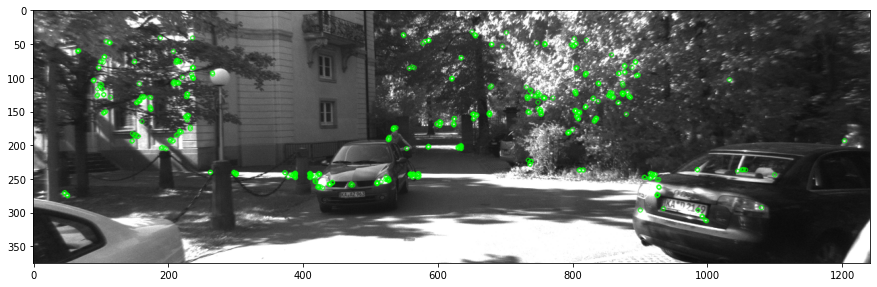

In [73]:
print("Features with ORB type detector")
_,_ = detect_features(imgL_0,det_type = 'orb', show=True)

### SIFT image descripter

Features with SIFT type detector


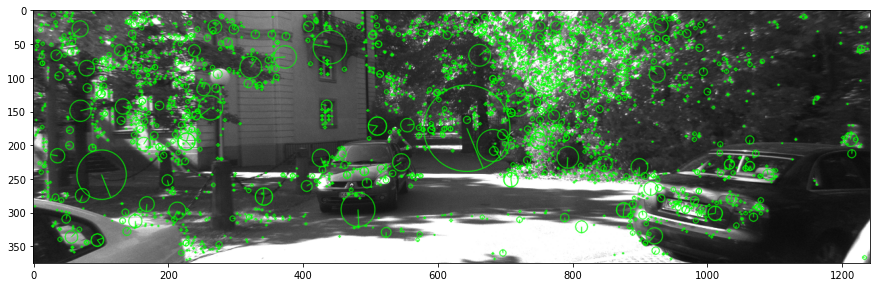

In [74]:
print("Features with SIFT type detector")
_,_ = detect_features(imgL_0, det_type='sift', show=True, flag=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 

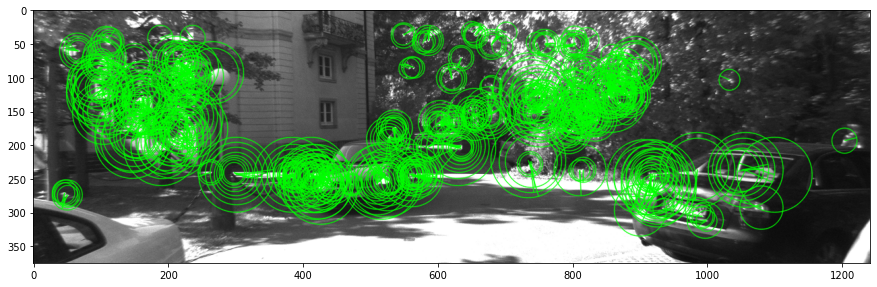

In [75]:
_,_ = detect_features(imgL_0, det_type='orb', show=True, flag=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 

## Detecting if features are valid:
<br>
<br>
<br>
<br>


Outlier rejection:
    
    Lowe's ratio
    - closest feature match needs to be >2x closer than the next feature.
    

In [76]:
def get_valid_features(im0, im1, detector, matcher, flann_checks = 50, lowes_ratio = 0.5):
    # convert to grayscale if not already
    if len(im0.shape)>2:
        gray=cv2.cvtColor(im0,  cv2.COLOR_RGB2GRAY)
    else:
        gray=im0.copy()

    if detector.lower() == 'orb':
        # ORB detector
        det = cv2.ORB_create()
    elif detector.lower() == 'sift':
        # SIFT Detector
        det = cv2.SIFT_create()
    # elif det_type.lower() == 'surf':
    #     # SURF Detector
    #     det = cv2.xfeatures2d.SURF_create()


    kp1, des1 = det.detectAndCompute(im0, None)
    kp2, des2 = det.detectAndCompute(im1,None)
    print(f"Number of keypoints found in img1:{len(kp1)}\nNumber of keypoints found in img2:{len(kp2)}\n")
    
    if matcher.lower() =='bf':
        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2,k=2)

    elif matcher.lower() == 'flann':
        FLANN_INDEX_KDTREE = 1
        if det_type.lower ==  'orb':
            FLANN_INDEX_LSH = 6
            index_params= dict(algorithm = FLANN_INDEX_LSH,
                       table_number = 6, # 12
                       key_size = 12,     # 20
                       multi_probe_level = 1) #2
        else:
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    
        search_params = dict(checks=flann_checks)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < lowes_ratio*n.distance:
            good.append([m])
    print("Number of matches:", len(matches))

    print("Number of GOOD matches:", len(good))

    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(im0,kp1,im1,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=im_fig_size);plt.imshow(img3),plt.show()
    
    return kp1, kp2, good
    

Number of keypoints found in img1:3124
Number of keypoints found in img2:3189

Number of matches: 3124
Number of GOOD matches: 814


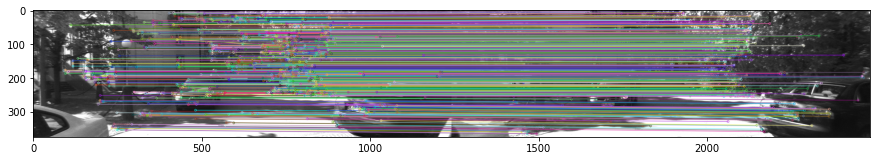

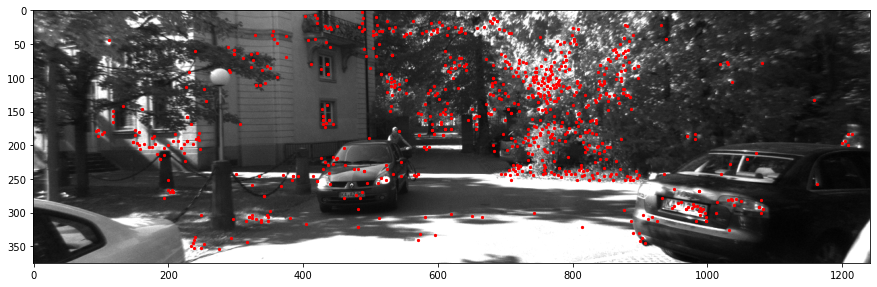

In [77]:
det_type='sift'; matcher='bf'; 
im0 = imgL_0
im1 = np.array(data.get_cam0(1))

kp1, kp2, good = get_valid_features(im0, im1, det_type, matcher)

plt.figure(figsize=im_fig_size)
plt.imshow(im0, 'gray')

xy1 = np.zeros((len(good),2))
for i in range(len(good)):
    m=good[i][0].queryIdx
    xy1[i] = np.round(kp1[m].pt).astype(int)
plt.scatter(xy1[:,0], xy1[:,1],s=5,c='r')

plt.show()

In [78]:
def get_valid_features_multi_frame(im0_arr, im1_arr, detector, matcher, flann_checks = 50, lowes_ratio = 0.5):
    num_frames = im0_arr.shape[0]
    if detector.lower() == 'orb':
        # ORB detector
        det = cv2.ORB_create()
    elif detector.lower() == 'sift':
        # SIFT Detector
        det = cv2.SIFT_create()
    # elif det_type.lower() == 'surf':
    #     # SURF Detector
    #     det = cv2.xfeatures2d.SURF_create()
    
    kp_im0, des_im0 = [],[]
    kp_im1, des_im1= [],[]
    for f in np.arange(num_frames):
        im0 = np.array(im0_arr[f])
        kp0, des0 =  det.detectAndCompute(im0, None)
        kp_im0.append(kp0); des_im0.append(des0)
        im1 = np.array(im1_arr[f])
        kp1, des1 =  det.detectAndCompute(im1, None)
        kp_im1.append(kp1); des_im1.append(des1)
        
    print(f"Number of keypoints found in img1 frame 0:{len(kp_im0[0])}\nNumber of keypoints found in img2 frame 0:{len(kp_im1[0])}\n")
    
    if matcher.lower() =='bf':
        # BFMatcher with default params
        matcher = cv2.BFMatcher()
#         matches = bf.knnMatch(des1,des2,k=2)

    elif matcher.lower() == 'flann':
        FLANN_INDEX_KDTREE = 1
        if det_type.lower ==  'orb':
            FLANN_INDEX_LSH = 6
            index_params= dict(algorithm = FLANN_INDEX_LSH,
                       table_number = 6, # 12
                       key_size = 12,     # 20
                       multi_probe_level = 1) #2
        else:
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    
        search_params = dict(checks=flann_checks)   # or pass empty dictionary
        matcher = cv2.FlannBasedMatcher(index_params,search_params)
#         matches = flann.knnMatch(des1,des2,k=2)
    
    # check matches to descriptor for im0 frame0 
    for f in np.arange(1,num_frames):
        matches = matcher.knnMatch(des_im0[0], des_im0[f], k=2)
        
        if f==0:
            print("Number of matches with im0 frame", f, " :", len(matches))
            
        
        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < lowes_ratio*n.distance:
                good.append([m])
        print("Number of GOOD matches im0 frame", f, " :", len(good))
        
        matches2 = matcher.knnMatch(des_im0[0], des_im0[f], k=2)
        
        # Apply ratio test
        good2 = []
        for m,n in matches2:
            if m.distance < lowes_ratio*n.distance:
                good2.append([m])
#         print("Number of matches with im1 frame", f, " :", len(matches2))
        print("Number of GOOD matches im1 frame", f, " :", len(good2))
        
        plt.figure(figsize=im_fig_size)
        plt.imshow(im0_arr[0], 'gray')

        xy1 = np.zeros((len(good),2))
        for i in range(len(good)):
            m=good[i][0].queryIdx
            xy1[i] = np.round(kp1[m].pt).astype(int)
        plt.scatter(xy1[:,0], xy1[:,1],s=5,c='r')

        plt.show()
        
    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(im0_arr[0],kp_im0[f],im1_arr[f],kp_im1[f],good2,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=im_fig_size);plt.imshow(img3),plt.show()
    

In [79]:
# num_frames = 5
# start = 0 
# imL_arr = np.zeros((num_frames, imgL.shape[0], imgL.shape[1]), dtype=np.uint8)
# imR_arr = np.zeros((num_frames, imgL.shape[0], imgL.shape[1]), dtype=np.uint8)

# for f in range(num_frames):
#     imL_arr[f] = data.get_cam0(start+f)
#     imR_arr[f] = data.get_cam1(start+f)
    
# get_valid_features_multi_step(imL_arr,imR_arr, detector="sift", matcher="bf")
# # get_valid_features_multi_step(imL_arr,imR_arr, detector="orb", matcher="bf")

# Sampling Pointclouds
---


<br>
<br>
<br>

Options for sampling:
- Decimating (n^th point subsampling)
- Minimum didstance
- Voxel grid

<br>
<br>
<br>


Voxel grid will be the main method investigated. The downsides are:
- grid will require tuning in future based on how accurate a map is required to be. 
- Max dimensions will need to be known in advance for X Y and Z.

Later in the research this will need to be revisited.
<br>
For this reason, minimum distance may be the best option for dynamic point clouds.


<br>
<br>
<br>
Point for further research:
- How to chose which sample to keep?


<br>
<br>
<br>

## Setting up variables:

In [80]:
# Sanity check to see if the points were projected correctly
# %matplotlib notebook
%matplotlib inline
def setup_img_render_lidarMask(frame, get_mask=True):
    img = np.array(data.get_cam2(frame))
    lidar_render = pointcloud_to_image( data.get_velo(frame), img.shape[0], img.shape[1], data.calib.T_cam2_velo, data.calib.P_rect_20, useDepth=True)

    if get_mask:
        # Making a lidar mask
        tmp = cv2.dilate(lidar_render, np.ones((10, 10))).astype(np.uint8)
        thresh = 20
        canny_output = cv2.Canny(tmp, thresh, thresh * 2)

        lidar_mask = np.zeros(img.shape)
        for i in range(canny_output.shape[1]):
            col = canny_output[:, i]
            #     print(np.argmax(col>0))
            lidar_mask[0 : np.argmax(col > 0), i, :] = 1
        lidar_mask = np.logical_not(lidar_mask)
        return img, lidar_render, lidar_mask
    
    return img, lidar_render

imgL, render, lidar_mask = setup_img_render_lidarMask(frame=0)

idx = np.array(np.where(render>0))
full_mesh_render_pts = np.stack((idx[1], idx[0],render[idx[0], idx[1]])).T



# plt.imshow(imgL)
# plt.show()

# plt.imshow(render)
# plt.show()

# plt.figure(figsize=im_fig_size)
# plt.imshow(lidar_mask)
# plt.title("Mask of lidar points")
# plt.show()

In [81]:

# plt.figure(figsize=im_fig_size)
# plt.imshow(imgL)
# plt.axis('off')
# plt.show()

# plt.figure(figsize=im_fig_size)
# plt.imshow(render)
# plt.title("Pointcloud in image frame coloured by depth")
# plt.axis('off')
# plt.show()


# plt.figure(figsize=im_fig_size)
# plt.scatter(full_mesh_render_pts[:,0], -full_mesh_render_pts[:,1], c=full_mesh_render_pts[:,2], s=1)
# plt.title("Mesh points Scattered and coloured by depth")
# plt.axis('equal')
# plt.xlabel("U")
# plt.ylabel("-V")
# plt.ylim([-350,0])
# plt.show()

# fig=plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_title("Triangulation")
# ax.set_xlabel("U")
# ax.set_ylabel("-V")
# ax.set_zlabel("Z")
# # ax.axis('off')
# ax.plot_trisurf(mesh_render_pts[:, 0],
#                 -mesh_render_pts[:, 1],
#                 mesh_render_pts[:, 2],
#                 color='none',
#                 edgecolor='blue',
#                 triangles=mesh_render.simplices[::2])
# ax.set_zlim([0,100])
# ax.set_ylim([0,-render.shape[1]])
# ax.view_init(elev=-65, azim=-90)
# plt.show()


In [82]:
plt.close('all')


## Sampling the good image features

Using a sift feature descripter to find the best features in the image. 

These are used to make a mesh.

If needed, they can be downsampled further.

In [83]:
lidar_mask.shape

(375, 1242, 3)

In [84]:
def get_uv_ft(lidar_mask, img):
    kp_sift, des_sift = detect_features(lidar_mask*img, det_type='sift', show=False,flag=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 


    decimation_factor=1

    uv_ft = -1*np.ones((np.ceil(len(kp_sift)/decimation_factor).astype(int), 2), dtype=int)


    for i in range(0,len(kp_sift)//decimation_factor):
        uv_ft[i] = np.round(kp_sift[i].pt).astype(int)

    right_pts = np.where(np.logical_not(uv_ft[:,1]>imgL.shape[0]) +
                        (uv_ft[:,1]<0) +
                        (uv_ft[:,0]>imgL.shape[1])+
                        (uv_ft[:,0]<0))

#     print(f"Number of points out of frame = {np.sum(right_pts==False)}")
    uv_ft = uv_ft[right_pts]
    return uv_ft

uv_ft = get_uv_ft(lidar_mask, imgL)

In [85]:
uvd_ft_lidar = -1*np.ones((uv_ft.shape[0],3))
# uvd_ft_lidar = interpolate_mesh_pts(mesh_render, mesh_render_pts[:,:2],mesh_render_pts )


mesh_render_pts = full_mesh_render_pts[::50]
mesh_render = Delaunay(mesh_render_pts[:,:2])
tmp = interpolate_mesh_pts(mesh_render, uv_ft,mesh_render_pts,precision=5 )




mesh_render_pts = full_mesh_render_pts
mesh_render = Delaunay(mesh_render_pts[:,:2])
uvd_ft_lidar = interpolate_mesh_pts(mesh_render, uv_ft,mesh_render_pts,precision=5 )
# print(uv_ft.shape)
# print(uvd_ft_lidar.shape)


# # plt.figure(figsize=im_fig_size)
# plt.figure(figsize=im_fig_size)
# plt.scatter(mesh_render_pts[:,0],-mesh_render_pts[:,1],s=5)
# plt.scatter(mesh_render_pts[:,0][::50], -mesh_render_pts[:,1][::50], s=10, c='orange')
# plt.axis('off')
# plt.show()


# print(f"Error in [X, Y, Z]: {np.linalg.norm(uvd_ft_lidar-tmp, axis=0)}")
# # print(f"Error in Y: {np.linalg.norm(uvd_ft_lidar[:,1]-tmp[:,1])}")
# # print(f"Error in Z: {np.linalg.norm(uvd_ft_lidar[:,2]-tmp[:,2])}")



Number of points out of frame = 0


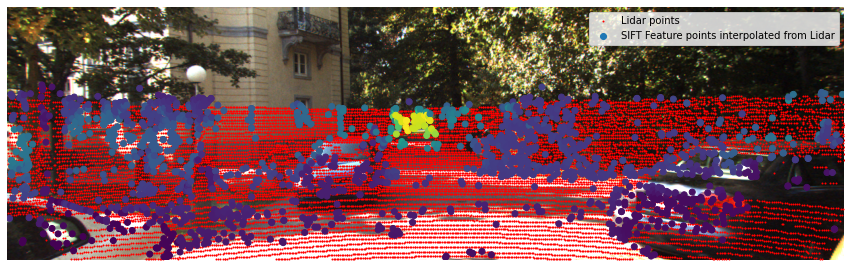

In [86]:
in_frame_pts = np.where(np.logical_not((uvd_ft_lidar[:,1]>imgL.shape[0]) + 
                                       (uvd_ft_lidar[:,1]<0) + 
                                       (uvd_ft_lidar[:,0]>imgL.shape[1]) + 
                                       (uvd_ft_lidar[:,0]<0)))



print(f"Number of points out of frame = {uvd_ft_lidar.shape[0] - uvd_ft_lidar[in_frame_pts].shape[0]}")
uvd_ft_lidar = np.hstack((uv_ft[in_frame_pts], uvd_ft_lidar[in_frame_pts,2].reshape((-1,1))))




fig = plt.figure(figsize=im_fig_size)
ax = fig.add_subplot(111)
ax.imshow(imgL)

# ax.scatter(uv_ft[:,0], uv_ft[:,1])
ax.scatter(mesh_render_pts[:,0], mesh_render_pts[:,1],s=1, c='red',label="Lidar points")
ax.scatter(uvd_ft_lidar[:,0], uvd_ft_lidar[:,1], c=uvd_ft_lidar[:,2], label="SIFT Feature points interpolated from Lidar")

ax.axis('off')

ax.legend()

plt.show()

In [87]:
plt.close('all')

## Decimating

Sampling every nth lidar point. 
Gives sparse representation at distance.


Starting number of points: 1803
End number of points after decimating: 19 



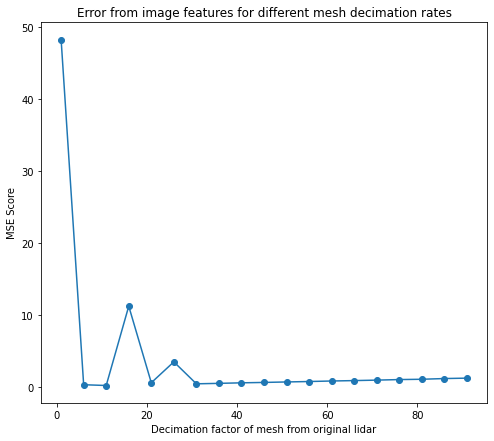

In [88]:
def get_sample_decimation_errors(full_points, samples, d_factors=[], min_points=100, bounding=[], debug=False):
    if len(d_factors) == 0:
        d_factors = np.arange(1, 500, 500 // 100, dtype=int)

    errors = []
    mesh = Delaunay(full_points[:, :2])
    if debug:
        print("\nStarting number of points:", len(samples[:: d_factors[0]]))

    #     while deci_s.shape[0]>min_points:
    for i, d_factor in enumerate(d_factors):
        deci_s = samples[::d_factor]
        if len(deci_s) < min_points:
            d_factors = d_factors[:i]
            break
        else:
            errors.append(get_mesh_error(mesh, deci_s, full_points, bounding_shape=bounding))
    #         deci_s = deci_s[::d_factor]
    if debug:
        print("End number of points after decimating:", len(deci_s), "\n")
    return np.array(errors), d_factors


errors, decimation_factors = get_sample_decimation_errors(
    full_mesh_render_pts, uvd_ft_lidar, min_points=20, bounding=imgL.shape, debug=True
)


fig = plt.figure(figsize=[8, 7])
ax = fig.add_subplot(111)

ax.plot(decimation_factors, errors, "o-")

ax.set_title("Error from image features for different mesh decimation rates")
ax.set_ylabel("MSE Score")  # [$x10^3$]")
ax.set_xlabel("Decimation factor of mesh from original lidar")

plt.show()

In [89]:
plt.close('all')

## Grid Pointcloud Sampling
<br>
<br>
<br>
<br>

### Choice of point selection:

- random (control)
- mean
- median
- closest to center
- best image feature (and if there's no feature?)

In [90]:
def get_grid_pt(uvd, grid_step, method="avg", features=[], fix=True):
    use_ft = False
    if np.shape(features)[0] > 0:
        use_ft = True
    elif method.find("feature") > -1:
        print("Error: no features supplied")
        return []

    u = np.hstack(
        (
            np.arange(uvd[:, 1].min().astype(int), uvd[:, 1].max().astype(int), grid_step),
            mesh_render_pts[:, 1].max().astype(int),
        )
    )
    v = np.hstack(
        (
            np.arange(uvd[:, 0].min().astype(int), uvd[:, 0].max().astype(int), grid_step),
            mesh_render_pts[:, 0].max().astype(int),
        )
    )

    if method.lower() != "all":
        grid_pts = -np.ones((len(u) * len(v), 3))
    else:
        pts_ld_avg = -np.ones((len(u) * len(v), 3))
        pts_ld_median = -np.ones((len(u) * len(v), 3))
        pts_ld_closest = -np.ones((len(u) * len(v), 3))
        pts_ld_avg_c = -np.ones((len(u) * len(v), 3))
        pts_ld_median_c = -np.ones((len(u) * len(v), 3))
        pts_ld_closest_c = -np.ones((len(u) * len(v), 3))

        if use_ft:
            pts_ft = -np.ones((len(u) * len(v), 3))
            pts_ft_c = -np.ones((len(u) * len(v), 3))

   
    for j in range(len(v) - 1):
        for i in range(len(u) - 1):
            midpt = np.array((v[j], u[i])) + 0.5 * grid_step
            if midpt[0]>uvd[:,0].max():
                midpt[0] = uvd[:,0].max()
            if midpt[1]>uvd[:,1].max():
                midpt[1] = uvd[:,1].max()
                
            block = uvd[
                np.where(
                    np.logical_and(
                        np.logical_and(uvd[:, 1] >= u[i], (uvd[:, 1] <= u[i + 1])),
                        np.logical_and(uvd[:, 0] >= v[j], (uvd[:, 0] <= v[j + 1])),
                    )
                )
            ]

            if block.shape[0] > 0:

                #         grid_ld_avg[non_empty_grid_keys[index,0],non_empty_grid_keys[index,1]] = np.mean(pts, axis=0)
                #         grid_ld_median[non_empty_grid_keys[index,0],non_empty_grid_keys[index,1]] = np.median(pts, axis=0)
                #         grid_ld_closest[non_empty_grid_keys[index,0],non_empty_grid_keys[index,1]] =np.hstack((midpt, pts[np.argmin(np.linalg.norm(pts[:,:2] - midpt )),2]))
                if method.lower() == "avg":
                    d = np.mean(block[:, 2])
                    grid_pts[j * len(u) + i] = block[np.argmin(np.linalg.norm(block - d))]

                if method.lower() == "median":
                    d = np.median(block[:, 2])
                    grid_pts[j * len(u) + i] = block[np.argmin(np.linalg.norm(block - d))]

                if method.lower() == "center":
                    grid_pts[j * len(u) + i] = block[np.argmin(np.linalg.norm(block[:, :2] - midpt))]
                    if fix:
                        grid_pts[j * len(u) + i, :2] = midpt

                if method.lower() == "feature" and use_ft:
                    i = np.argmin(np.linalg.norm(features[:, :2] - np.mean(block[:, :2], axis=0), axis=1))
                    grid_pts[index] = features[i]

                if method.lower() == "all":
                    pts_ld_avg[j * len(u) + i] = np.mean(block, axis=0)
                    pts_ld_median[j * len(u) + i] = np.median(block, axis=0)
                    pts_ld_closest[j * len(u) + i] = np.hstack(
                        (midpt, block[np.argmin(np.linalg.norm(block[:, :2] - midpt)), 2])
                    )

                    f = np.hstack((midpt, np.mean(block, axis=0)[2]))
                    pts_ld_avg_c[j * len(u) + i] = f
                    f = np.hstack((midpt, np.median(block, axis=0)[2]))
                    pts_ld_median_c[j * len(u) + i] = f
                    f = np.hstack((midpt, np.mean(block, axis=0)[2]))
                    pts_ld_closest_c[j * len(u) + i] = np.hstack(
                        (midpt, block[np.argmin(np.linalg.norm(block[:, :2] - midpt)), 2])
                    )

                    if use_ft:
                        fp = np.argmin(np.linalg.norm(features[:, :2] - np.mean(block[:, :2], axis=0), axis=1))
                        pts_ft[j * len(u) + i] = features[fp]
                        f = np.hstack((midpt, features[fp, 2]))
                        pts_ft_c[j * len(u) + i] = f

    if method.lower() != "all":
        grid_pts = grid_pts[np.where(grid_pts[:, 2] > -1)]
        return grid_pts

    else:
        pts_ld_avg = pts_ld_avg[np.where(pts_ld_avg[:, 2] > -1)]
        pts_ld_median = pts_ld_median[np.where(pts_ld_median[:, 2] > -1)]
        pts_ld_closest = pts_ld_closest[np.where(pts_ld_closest[:, 2] > -1)]
        pts_ld_avg_c = pts_ld_avg_c[np.where(pts_ld_avg_c[:, 2] > -1)]
        pts_ld_median_c = pts_ld_median_c[np.where(pts_ld_median_c[:, 2] > -1)]
        pts_ld_closest_c = pts_ld_closest_c[np.where(pts_ld_closest_c[:, 2] > -1)]
        if use_ft:
            pts_ft = pts_ft[np.where(pts_ft[:, 2] > -1)]
            pts_ft_c = pts_ft_c[np.where(pts_ft_c[:, 2] > -1)]

            return [
                pts_ld_avg,
                pts_ld_median,
                pts_ld_closest,
                pts_ld_avg_c,
                pts_ld_median_c,
                pts_ld_closest_c,
                pts_ft,
                pts_ft_c,
            ]

        return [pts_ld_avg, pts_ld_median, pts_ld_closest, pts_ld_avg_c, pts_ld_median_c, pts_ld_closest_c]

In [91]:
# for i in range(5,200,25):
#     pts = get_grid_pt(mesh_render_pts, i, method="avg")#, features=uvd_ft_lidar)
# #     pts = pts[pts[:,1]==150]    
#     plt.figure(figsize=im_fig_size)
#     plt.imshow(imgL)#*lidar_mask)
#     plt.axis("equal")
#     plt.scatter(pts[:, 0], pts[:, 1], c='red')#c=pts[:, 2])
#     plt.show()
# #     break

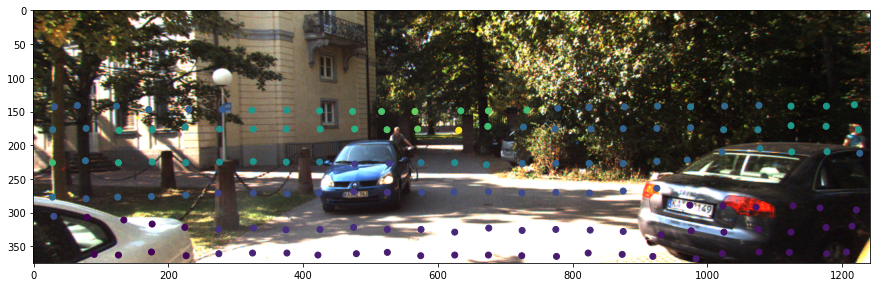

In [92]:
mesh_render_pts = full_mesh_render_pts.copy()

plt.figure(figsize=im_fig_size)
tmp = mesh_render_pts.copy()
# plt.imshow(render_points(tmp, dilation_size=10))
plt.imshow(imgL)

gs = 50
u = np.hstack((np.arange(0, mesh_render_pts[:, 1].max().astype(int), gs), mesh_render_pts[:, 1].max().astype(int)))
v = np.hstack((np.arange(0, mesh_render_pts[:, 0].max().astype(int), gs), mesh_render_pts[:, 0].max().astype(int)))
pts = -np.ones((len(u) * len(v), 3))
c = 0
for j in range(len(v) - 1):
    for i in range(len(u) - 1):
        #         print(f"[{v[j]}:{v[j+1]}, {u[i]}:{u[i+1]}]")

        #         block = mesh_render_pts[u[i]:u[i+1], v[j]:v[j+1]]
        #         idxs = np.where(np.logical_and(np.logical_and(tmp[:,1]>=u[i], (tmp[:,1]<=u[i+1])),np.logical_and(tmp[:,0]>=v[i], (tmp[:,0]<=v[i+1]))))

        block = tmp[
            np.where(
                np.logical_and(
                    np.logical_and(tmp[:, 1] >= u[i], (tmp[:, 1] <= u[i + 1])),
                    np.logical_and(tmp[:, 0] >= v[j], (tmp[:, 0] <= v[j + 1])),
                )
            )
        ]
        if block.shape[0] > 0:
            #             print("[",block[:,0].min(), ":", block[:,0].max(), ",", block[:,1].min(), ":", block[:,1].max(),"]")
            pts[j * len(u) + i] = np.median(block, axis=0)
pts = pts[np.where(pts[:, 2] > -1)]

plt.scatter(pts[:, 0], pts[:, 1], c=pts[:, 2])
plt.show()

In [93]:
# g_s = get_avg_median_center_grids(full_mesh_render_pts, 20, uvd_ft_lidar)    
# grid_avg = g_s[0]
# grid_median = g_s[1]
# print(grid_avg.shape)

# plt.figure(figsize=im_fig_size)

# plt.imshow(imgL)

# tmp = grid_avg.reshape((-1,3))
# tmp = tmp[tmp.sum(axis=1)>0]
# e_avg, decimation = get_sample_decimation_errors(full_mesh_render_pts, tmp)

# plt.scatter(tmp[:,0], tmp[:,1], c='magenta', marker="X", s=60, label="Mean Point")
# # plt.axis("equal")
# # plt.show()

# tmp = grid_median.reshape((-1,3)) 
# tmp = tmp[tmp.sum(axis=1)>0]
# e_median, decimation = get_sample_decimation_errors(full_mesh_render_pts, tmp, )


# plt.scatter(tmp[:,0], tmp[:,1], c='chartreuse', marker="X", s=60, label="Median Point")
# plt.axis("equal")


# plt.title("Median feature vs Mean feature")
# plt.legend()
# plt.axis('off')

# plt.show()

In [94]:
# decimation =np.arange(1,20, dtype=int)
# # grid_avg, grid_median, grid_center, grid_ft = get_avg_median_center_grids(full_mesh_render_pts, 30, uvd_ft_lidar)
# grid_avg, grid_median, grid_center, grid_ft = g_s[0:4]  # get_avg_median_center_grids(full_mesh_render_pts, 30, uvd_ft_lidar)



# tmp = grid_avg.reshape((-1,3))
# tmp = tmp[tmp.sum(axis=1)>0]
# e_avg, d_avg = get_sample_decimation_errors(full_mesh_render_pts, tmp,d_factors=decimation, min_points=20, debug=True)


# tmp = grid_median.reshape((-1,3))
# tmp = tmp[tmp.sum(axis=1)>0]
# e_median, d_median = get_sample_decimation_errors(full_mesh_render_pts, tmp,d_factors=decimation, min_points=20, debug=True)


# tmp = grid_ft.reshape((-1,3))
# tmp = tmp[tmp.sum(axis=1)>0]
# e_ft, d_ft = get_sample_decimation_errors(full_mesh_render_pts, tmp,d_factors=decimation, min_points=20, debug=True)


# tmp = grid_center.reshape((-1,3))
# tmp = tmp[tmp.sum(axis=1)>0]
# e_center, d_center = get_sample_decimation_errors(full_mesh_render_pts, tmp,d_factors=decimation, min_points=20, debug=True)

In [95]:
# fig = plt.figure(figsize=[10,8])



# # plt.plot(d_avg,e_avg,'-o', label="Average lidar Pt")
# # plt.plot(d_median,e_median,'-o', label="Median lidar Pt")
# # plt.plot(d_center,e_center,'-o', label="Closest lidar Pt to center")
# # plt.plot(d_ft,e_ft,'-o', label="Feature pt nearest avg")


# avg_length = 5
# plt.plot(d_avg[:1-avg_length],moving_average(e_avg, avg_length),'-o', label="Average lidar Pt")
# plt.plot(d_median[:1-avg_length],moving_average(e_median, avg_length),'-o', label="Median lidar Pt")
# plt.plot(d_center[:1-avg_length],moving_average(e_center, avg_length),'-o', label="Closest lidar Pt to center")
# plt.plot(d_ft[:1-avg_length],moving_average(e_ft, avg_length),'-o', label="Feature pt nearest avg")



# plt.title("Error in Grid points (at different decimation factors) against full resolution lidar mesh")
# plt.xlabel("Decimation rate for samples from original grid")
# plt.ylabel("Error")

# plt.legend()
# plt.show()

In [96]:



def test_grid_errors(g_steps, debug=False):
    e_avg_steps = np.zeros(len(g_steps))
    e_median_steps = np.zeros(len(g_steps))
    e_closest_steps = np.zeros(len(g_steps))
    e_ft_steps = np.zeros(len(g_steps))
    e_avg_c_steps = np.zeros(len(g_steps))
    e_median_c_steps = np.zeros(len(g_steps))
    e_closest_c_steps = np.zeros(len(g_steps))
    e_ft_c_steps = np.zeros(len(g_steps))

    mesh_render = Delaunay(full_mesh_render_pts[:, :2])

    # for i,s in enumerate(g_steps[::10]):
    for i, s in enumerate(g_steps):
        #     g_avg, g_median, g_ft = get_avg_median_center_grids(full_mesh_render_pts, s, uvd_ft_lidar)[:3]
        if debug:
            print("Step size:", s)

        g_avg, g_median, g_closest, g_avg_c, g_median_c, g_closest_c, g_ft, g_ft_c = get_grid_pt(
            full_mesh_render_pts, s, method="all", features=uvd_ft_lidar
        )
        if debug:
            print("....... Mesh done")
        if debug:
            print("        Avg num pts:", g_avg.shape[0])

        #     e_avg_steps[i] = get_mesh_error(mesh_render, g_avg , full_mesh_render_pts, bounding_shape=imgL.shape)
        #     if debug: print(".", end="")
        #     e_median_steps[i] = get_mesh_error(mesh_render, g_median , full_mesh_render_pts, bounding_shape=imgL.shape)
        #     if debug: print(".", end="")
        #     e_closest_steps[i] = get_mesh_error(mesh_render, g_closest, full_mesh_render_pts, bounding_shape=imgL.shape)
        #     if debug: print(".", end="")
        #     e_ft_steps[i] = get_mesh_error(mesh_render, g_ft , full_mesh_render_pts, bounding_shape = imgL.shape)
        #     if debug: print(".", end="")

        #     e_avg_c_steps[i] = get_mesh_error(mesh_render, g_avg_c , full_mesh_render_pts, bounding_shape = imgL.shape)
        #     if debug: print(".", end="")
        #     e_median_c_steps[i] = get_mesh_error(mesh_render, g_median_c , full_mesh_render_pts, bounding_shape = imgL.shape)
        #     if debug: print(".", end="")
        #     e_closest_c_steps[i] = get_mesh_error(mesh_render, g_closest_c , full_mesh_render_pts, bounding_shape = imgL.shape)
        #     if debug: print(".", end="")
        #     e_ft_c_steps[i] = get_mesh_error(mesh_render, g_ft_c , full_mesh_render_pts, bounding_shape = imgL.shape)
        #     if debug: print(" Errors done")

        e_avg_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_avg[:, :2]),
            g_avg,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(".", end="")
        e_median_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_median[:, :2]),
            g_median,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(".", end="")
        e_closest_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_closest[:, :2]),
            g_closest,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(".", end="")
        e_ft_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_ft[:, :2]),
            g_ft,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(".", end="")

        e_avg_c_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_avg_c[:, :2]),
            g_avg_c,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(".", end="")
        e_median_c_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_median_c[:, :2]),
            g_median_c,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(".", end="")
        e_closest_c_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_closest_c[:, :2]),
            g_closest_c,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(".", end="")
        e_ft_c_steps[i] = get_mesh_interpolated_error(
            mesh_render,
            full_mesh_render_pts,
            Delaunay(g_ft_c[:, :2]),
            g_ft_c,
            image_shape=imgL.shape,
            interpolate_step_size=20,
            bounding_shape=imgL.shape,
        )
        if debug:
            print(" Errors done")

        print(".", end="")
        if len(g_avg) < 20:
            print(len(g_avg))
            break

    e_avg_steps = e_avg_steps[:i]
    e_median_steps = e_median_steps[:i]
    e_closest_steps = e_closest_steps[:i]
    e_ft_steps = e_ft_steps[:i]
    e_avg_c_steps = e_avg_c_steps[:i]
    e_median_c_steps = e_median_c_steps[:i]
    e_closest_c_steps = e_closest_c_steps[:i]
    e_ft_c_steps = e_ft_c_steps[:i]
    g_steps = g_steps[:i]

    return [
        e_avg_steps,
        e_median_steps,
        e_closest_steps,
        e_ft_steps,
        e_avg_c_steps,
        e_median_c_steps,
        e_closest_c_steps,
        e_ft_c_steps,
        g_steps,
    ]

In [97]:
if isfile("./Grid_errors.pkl"):
    #    No need to run the checks again
    # Just import from pickle
    infile = open("Grid_errors.pkl", "rb")
    e_and_steps = pickle.load(infile)
    infile.close()
    (
        e_avg_steps,
        e_median_steps,
        e_closest_steps,
        e_ft_steps,
        e_avg_c_steps,
        e_median_c_steps,
        e_closest_c_steps,
        e_ft_c_steps,
        g_steps,
    ) = e_and_steps

else:
    #     Need to run all the tests on grids again
    #     g_steps = np.arange(4, 40, 2)
    grid_steps = np.logspace(1, 8, base=2, num=50)
    debug = False

    e_and_steps = test_grid_errors(grid_steps, debug)

    outfile = open("Grid_errors.pkl", "wb")
    pickle.dump(e_and_steps, outfile)
    outfile.close()

    (
        e_avg_steps,
        e_median_steps,
        e_closest_steps,
        e_ft_steps,
        e_avg_c_steps,
        e_median_c_steps,
        e_closest_c_steps,
        e_ft_c_steps,
        g_steps,
    ) = e_and_steps

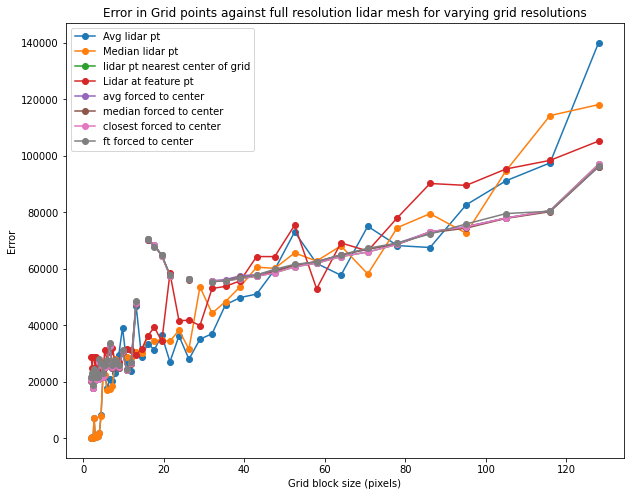

In [98]:
fig = plt.figure(figsize=[10,8])

avg_length = 5
x = g_steps[:1-avg_length]
x = g_steps

# plt.plot(x, moving_average(e_avg_steps, avg_length),'-o', label="Average lidar Pt")
# plt.plot(x,moving_average(e_median_steps, avg_length),'-o', label="Median lidar Pt")
# plt.plot(x,moving_average(e_ft_steps, avg_length),'-o', label="Closest Feature pt")

plt.plot(x,e_avg_steps, '-o', label = "Avg lidar pt")
plt.plot(x,e_median_steps, '-o', label = "Median lidar pt")
plt.plot(x,e_closest_steps, '-o', label = "lidar pt nearest center of grid")
plt.plot(x,e_ft_steps, '-o', label = "Lidar at feature pt")
plt.plot(x,e_avg_c_steps, '-o', label = "avg forced to center")
plt.plot(x,e_median_c_steps, '-o', label = "median forced to center")
plt.plot(x,e_closest_c_steps, '-o', label = "closest forced to center")
plt.plot(x,e_ft_c_steps, '-o', label = "ft forced to center")


# plt.plot(x,moving_average(e_avg_steps, avg_length), '-o', label = "Avg lidar pt")
# plt.plot(x,moving_average(e_median_steps, avg_length), '-o', label = "Median lidar pt")
# plt.plot(x,moving_average(e_closest_steps, avg_length), '-o', label = "lidar pt nearest center of grid")
# plt.plot(x,moving_average(e_ft_steps, avg_length), '-o', label = "Lidar at feature pt")
# plt.plot(x,moving_average(e_avg_c_steps, avg_length), '-o', label = "avg forced to center")
# plt.plot(x,moving_average(e_median_c_steps, avg_length), '-o', label = "median forced to center")
# plt.plot(x,moving_average(e_closest_c_steps, avg_length), '-o', label = "closest forced to center")
# plt.plot(x,moving_average(e_ft_c_steps, avg_length), '-o', label = "ft forced to center")

# g_closest
# ,
# ,g_median_c
# ,g_closest_c
# , g_ft_c



# plt.title("Moving Average Error in Grid points against full resolution lidar mesh for varying grid resolutions")
plt.title("Error in Grid points against full resolution lidar mesh for varying grid resolutions")

plt.xlabel("Grid block size (pixels)")
plt.ylabel("Error")

plt.legend()
plt.show()

In [99]:
plt.close('all')

In [100]:
# mesh_render = Delaunay(full_mesh_render_pts[:,:2])
# for i in range (10, 200, 25):
#     pts = get_grid_pt(full_mesh_render_pts,i)
    
    
#     plt.figure(figsize=im_fig_size)
#     plt.title(f"Step is {i}")
#     plt.imshow(imgL)
#     plt.scatter(pts[:,0], pts[:,1], c=pts[:,2])
    
# #     plt.triplot(pts[:,0], pts[:,1], triangles = Delaunay(pts[:,:2]).simplices)
#     plt.show()
    
    

### Displaying resulting pointclouds
<br>
<br>


In [101]:
g_s = get_avg_median_center_grids(full_mesh_render_pts, 10, uvd_ft_lidar)

ts = ["g_avg", "g_median", "g_closest", "g_avg_c", "g_median_c", "g_closest_c", "g_ft", " g_ft_c "]


plt.figure(figsize=im_fig_size)
plt.imshow(cv2.dilate(render, np.ones((5, 5))) / (render.max()))
for i, g in enumerate(g_s):

    g = g[np.where((g[:, 0] >= 0) & (g[:, 1] >= 0) & (g[:, 0] < imgL.shape[1]) & (g[:, 1] < imgL.shape[0]))]
    #     ax = fig.add_subplot(len(g_s),1,i+2)
    # ax.scatter(g_avg[:,0],-g_avg[:,1], c=g_avg[:,2])
    # ax.imshow(g_avg)
    #     ax.imshow(render_points(g, dilation_size=5))
    #     plt.figure(figsize=im_fig_size)
    #     plt.title(ts[i])
    #     plt.imshow(render_points(g, dilation_size=5))
    plt.scatter(g[:, 0], g[:, 1], s=3,label=ts[i])
#     plt.show()

#     ax.set_title("Grid points by avg contained lidar point")
# ax.set_ylim([-350, 0])
# ax.axis("equal")
plt.legend(loc="upper right")
# plt.axis('equal')
plt.axis("off")
plt.show()

NameError: name 'get_avg_median_center_grids' is not defined

# Verifying performance on smaller details
---

Testing how the different error metrics perform on smaller features

Want to be able to reconstruct narrow and small features but do not want dense meshes. 
Particularly interested in objects that are far from their background and are also small

In [ ]:
imgL, render, lidar_mask = setup_img_render_lidarMask(0)
imgL_masked = imgL[:,:,:]*np.hstack((lidar_mask,lidar_mask,lidar_mask)).reshape(imgL.shape)
plt.figure(figsize=im_fig_size)
plt.imshow(imgL)
plt.show()
plt.figure(figsize=im_fig_size)
plt.imshow(imgL_masked)
plt.show()

In [ ]:
lamppost_idx = [50,350,200,350]
right_car_idx = [120, 375, 850, 1242]
middle_car_idx = [120, 320, 350, 620]

rp_lamppost = render[lamppost_idx[0]:lamppost_idx[1], lamppost_idx[2]:lamppost_idx[3]]
rp_right_car = render[right_car_idx[0]:right_car_idx[1], right_car_idx[2]:right_car_idx[3]]
rp_middle_car = render[middle_car_idx[0]:middle_car_idx[1], middle_car_idx[2]:middle_car_idx[3]]

img_lamppost = imgL[lamppost_idx[0]:lamppost_idx[1], lamppost_idx[2]:lamppost_idx[3]]
img_right_car = imgL[right_car_idx[0]:right_car_idx[1], right_car_idx[2]:right_car_idx[3]]
img_middle_car = imgL[middle_car_idx[0]:middle_car_idx[1], middle_car_idx[2]:middle_car_idx[3]]


fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(1,3,1)
ax.imshow(cv2.blur(imgL,ksize=(2,2))[lamppost_idx[0]:lamppost_idx[1], lamppost_idx[2]:lamppost_idx[3],:])
ax = fig.add_subplot(1,3,2)
# ax.imshow(render_points(full_mesh_render_pts, dilation_size=2)[lamppost_idx[0]:lamppost_idx[1], lamppost_idx[2]:lamppost_idx[3]])
ax.imshow(rp_lamppost)
ax = fig.add_subplot(1,3,3)
ax.imshow(render_points(g_s[0], dilation_size=5)[lamppost_idx[0]:lamppost_idx[1], lamppost_idx[2]:lamppost_idx[3]])
plt.show()



fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(1,3,1)
ax.imshow(cv2.blur(imgL,ksize=(2,2))[right_car_idx[0]:right_car_idx[1], right_car_idx[2]:right_car_idx[3],:])
ax = fig.add_subplot(1,3,2)
ax.imshow(rp_right_car)
ax.imshow(render_points(full_mesh_render_pts, dilation_size=2)[right_car_idx[0]:right_car_idx[1], right_car_idx[2]:right_car_idx[3]])
ax = fig.add_subplot(1,3,3)
ax.imshow(render_points(g_s[0], dilation_size=5)[right_car_idx[0]:right_car_idx[1], right_car_idx[2]:right_car_idx[3]])
plt.show()

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(1,3,1)
ax.imshow(cv2.blur(imgL,ksize=(2,2))[middle_car_idx[0]:middle_car_idx[1], middle_car_idx[2]:middle_car_idx[3],:])
ax = fig.add_subplot(1,3,2)
# ax.imshow(render_points(full_mesh_render_pts, dilation_size=2)[middle_car_idx[0]:middle_car_idx[1], middle_car_idx[2]:middle_car_idx[3]])
ax.imshow(rp_middle_car)
ax = fig.add_subplot(1,3,3)
ax.imshow(render_points(g_s[0], dilation_size=5)[middle_car_idx[0]:middle_car_idx[1], middle_car_idx[2]:middle_car_idx[3]])
plt.show()


In [ ]:
def filter_points_to_mask(pts, mask, c=[], coord_correction=[], channel = 0):
    if len(coord_correction)>0:
        idx = pts[:,:2].T[::-1].T+[coord_correction[0],coord_correction[1]]
    else:
        idx=pts
    idx = idx.round().astype(int)
    
    if len(mask.shape) >2:
        mask = mask[:,:,channel]
    i = np.where(mask[idx[:,0], idx[:,1]]>0)
    pts = pts[i]
    if len(c)>0:
        c = c[i]
        return pts,c
    return pts

In [ ]:
fts = [rp_lamppost, rp_middle_car, rp_right_car]
ft_imgs  = [img_lamppost, img_middle_car, img_right_car]
selection_coords = [lamppost_idx, middle_car_idx, right_car_idx]

iss = 10


for i,ft in enumerate(fts):
    idx = np.array(np.where(ft>0)).T[:,::-1]
    pts = np.stack((idx[:,0], idx[:,1], ft[idx[:,1], idx[:,0]])).T
    grid = get_grid_pt(pts, 10)
    e, e_pts = get_mesh_interpolated_error(Delaunay(pts[:,:2]), pts, Delaunay(grid[:,:2]), grid, image_shape = ft.shape, interpolate_step_size=iss, return_vector=True, debug=False)

    e_pts, e = filter_points_to_mask(e_pts, lidar_mask, c=e, coord_correction=[selection_coords[i][0],selection_coords[i][2]])
    
    fig = plt.figure(figsize=im_fig_size)
    fig.set_tight_layout(True)
    ax = fig.add_subplot(121)
#     ax.axis("off")
    ax.set_title("Original image and corresponding sample points")
    ax.imshow(ft_imgs[i])
    ax.scatter(e_pts[:,0], e_pts[:,1], c=e, s=iss)#*iss*3)
    
    ax = fig.add_subplot(122)
    ax.axis("off")
    ax.set_title("Chart of the error by location")
    im = ax.imshow(render_points(np.stack((e_pts[:,0], e_pts[:,1],e)).T, img_shape=ft.shape,dilation_size=iss//2))#, colour_map=cm.hsv_r))
    # ax.colorbar()
    fig.colorbar(im, ax=ax)
    plt.show()

    fig = plt.figure(figsize=[10,5])
    ax= fig.add_subplot(111)
    ax.set_title("Histogram of error distribution")
    ax.set_xlabel("Error")
    ax.set_ylabel("Occurances")
    ax.hist(e, bins=20)
    plt.show()
    
    print("---------------------------------------------")
    print()
    print()
    print("---------------------------------------------")    

In [ ]:
grid
plt.imshow(ft_imgs[i])
plt.triplot(grid[:,0], grid[:,1], triangles=Delaunay(grid[:,:2]).simplices)
plt.scatter(grid[:,0], grid[:,1], c=grid[:,2])

plt.axis("equal")

In [ ]:
fts = [rp_lamppost, rp_middle_car, rp_right_car]
ft_imgs = [img_lamppost, img_middle_car, img_right_car]
selection_coords = [lamppost_idx, middle_car_idx, right_car_idx]

iss = 10

i = 1

# for i,ft in enumerate(fts):
ft = fts[i]
for iss in [2, 4, 12]:
    print("---------------------------------------------")
    print()
    print("Grid resolution is now:", iss, " Pixels")
    print()
    print("---------------------------------------------")

    idx = np.array(np.where(ft > 0)).T[:, ::-1]
    pts = np.stack((idx[:, 0], idx[:, 1], ft[idx[:, 1], idx[:, 0]])).T
    grid = get_grid_pt(pts, iss, method="avg")
    e, e_pts = get_mesh_interpolated_error(
        Delaunay(pts[:, :2]),
        pts,
        Delaunay(grid[:, :2]),
        grid,
        image_shape=ft.shape,
        interpolate_step_size=iss,
        return_vector=True,
#         debug=False,
    )
    

    e_pts, e = filter_points_to_mask(
        e_pts, lidar_mask, c=e, coord_correction=[selection_coords[i][0], selection_coords[i][2]]
    )

    
    fig = plt.figure(figsize=[15, 8])
    fig.set_tight_layout(True)
    ax = fig.add_subplot(121)
    #     ax.axis("off")
    ax.set_title("Original image and corresponding sample points")
    ax.imshow(ft_imgs[i])
    ax.scatter(e_pts[:, 0], e_pts[:, 1], c=e, s=iss * iss, cmap=cm.Accent_r)  # *iss*3)

    ax = fig.add_subplot(122)
    ax.axis("off")
    ax.set_title("Chart of the error by location")
    im = ax.imshow(
        render_points(np.stack((e_pts[:, 0], e_pts[:, 1], e)).T, img_shape=ft.shape, dilation_size=iss)
    )  # , colour_map=cm.hsv_r))
    # ax.colorbar()
#     fig.colorbar(im, ax=ax)
    plt.show()


# -------------------------------------------------------------
# Histogram plot
# -------------------------------------------------------------

#     fig = plt.figure(figsize=[10,5])
#     ax= fig.add_subplot(121)
#     ax.set_title("Histogram of error distribution")
#     ax.set_xlabel("Error")
#     ax.set_ylabel("Occurances")
#     ax.hist(e, bins=50)
#     plt.show()

First fix:

- [x] Error metrics needs to be improved 

- [ ] point errors not matching
- [ ] use python bindings on github to get dense interpolations
- [ ] compare point to point on depth map with interpolation

<br>
<br>
<br>

then:

selecting features by hand. 
* [ ] must make a mesh
* [ ] get dense depth map over new image and mesh
* [ ] compare mesh error
* [ ] get error on points


## Minimum Distance Sampling

<br>

<br>

<br>



In [ ]:
lamppost_idx[0]

In [ ]:
imgL.shape

In [ ]:
plt.close("all")

# Making video of results

In [ ]:
from ipywidgets import Video
from IPython.

In [ ]:
out = cv2.VideoWriter('drive.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, imgL.shape[:2], isColor=True)
 
for i in range(len(data.velo_files)):
    out.write(np.array(data.get_cam3(i)))
out.release()

In [ ]:
width = 1242
height = 375
FPS = 5
# seconds = 10
frames = len(data.velo_files)

fourcc = cv2.VideoWriter_fourcc(*"MP42")
video = cv2.VideoWriter("./drive.mp4", fourcc, float(FPS), (width, height))

for i in range(frames):
    #     frame = np.array(data.get_cam3(i))
    frame, render, lidar_mask = setup_img_render_lidarMask(i, get_mask=True)
    idx = np.array(np.where(render > 0))
    full_mesh_render_pts = np.stack((idx[1], idx[0], render[idx[0], idx[1]])).T

    uv_ft = get_uv_ft(lidar_mask, frame)

    mesh_render_pts = full_mesh_render_pts[::100]
    mesh_render = Delaunay(mesh_render_pts[:, :2])
    uvd_ft_lidar = interpolate_mesh_pts(mesh_render, uv_ft, mesh_render_pts, precision=5)

    grid_pts = get_grid_pt(full_mesh_render_pts, 40, method="feature", features=uvd_ft_lidar)
    img_grid = render_points(grid_pts, imgL.shape, dilation_size=5, colour_map=cm.Accent)
#     img_grid = np.array(255 * img_grid / img_grid.max(), dtype=np.uint8)
#     img_grid = cv2.cvtColor(img_grid, cv2.COLOR_GRAY2BGR)
    idx = np.where(img_grid.sum(axis=2)>0)
    idx = np.where(img_grid > 0)

    frame[idx[0], idx[1]] = img_grid[idx[0], idx[1]]

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
    video.write(frame)
    print(".", end="")
video.release()

In [ ]:
player = Video.from_file("./drive.mp4")
player

In [ ]:
plt.tripcolor(
    mesh_render_pts[:, 0],
    mesh_render_pts[:, 1],
    triangles=mesh_render.simplices.copy(),
    facecolors=-(mesh_render_pts[mesh_render.simplices].sum(axis=1)/3)[:,2],
    edgecolors='k',
)

In [ ]:
grid_pts = get_grid_pt(full_mesh_render_pts,40, method="feature", features=uvd_ft_lidar)

img_render = render_points(grid_pts, imgL.shape, dilation_size=5, colour_map=cm.Accent)
idx = np.where(img_render.sum(axis=2)>0)
frame[idx[0], idx[1]] = img_render[idx[0], idx[1]]

In [ ]:
plt.figure(figsize=im_fig_size)
plt.imshow(frame)

In [ ]:
tmp = np.ones(imgL.shape)

tmp[grid_pts[:,0], grid_pts[:,1]] = cs[:,:3]

In [ ]:
mesh_render_pts = grid_pts
mesh_render = Delaunay(grid_pts[:,:2])
plt.imshow(frame)
plt.triplot(mesh_render_pts[:,0], mesh_render_pts[:,1], triangles=mesh_render.simplices)

In [ ]:


print(len(mesh_render_pts[:, 0]))
print(len(mesh_render_pts[: len(colors), 1]))
print(len(mesh_render.simplices.copy()))
print(len(colors))

In [ ]:
h = 300
w = 1000
npts = len(mesh_render_pts[:,1])
pts = np.zeros((npts,2))
pts[:,0] = np.random.randint(0,w,npts)
pts[:,1] = np.random.randint(0,h,npts)
tri = Delaunay(pts)
plt.xlim(0, w)
plt.ylim(0, h)
centers = np.sum(pts[tri.simplices], axis=1, dtype='int')/3.0
colors = np.array([ (x-w/2.)**2 + (y-h/2.)**2 for x,y in centers])
plt.tripcolor(pts[:,0], pts[:,1], tri.simplices.copy(), facecolors=colors, edgecolors='k')
plt.gca().set_aspect('equal')
plt.show()